<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>CoVID-19</h1>
<h1>Visualizing individual patient data</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

from collections import Counter

import wget
import os

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

numpy      1.18.1
autopep8   1.5
wget       3.2
cartopy    0.18.0
pandas     1.0.1
watermark  2.0.2
matplotlib 3.1.3
json       2.0.9
Sun Jun 21 2020 

CPython 3.7.3
IPython 6.2.1

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : faef23e22b9a44430143099ca013ff07cbbafda2


Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Patient data

The file stored in the original github repository is continuously updated

In [4]:
url = 'https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/'
file = 'latestdata.tar.gz'

Check that we have a copy or download it if we dont

In [5]:
if not os.path.exists('data/' + file):
    print('Downloading file...', end='')
    fp = wget.download(url + file, 'data/' + file)
    print("DONE")

Load the file using pandas

In [6]:
data = pd.read_csv('data/' + file, parse_dates=False, dtype='str',
                  usecols=['latitude', 'longitude', 'country', 'sex', 'age', 'date_confirmation', 'date_onset_symptoms'])

The file has a [long list of fields](https://www.nature.com/articles/s41597-020-0448-0), but only a few are useful for our purposes, so we load only those to save memory. In total we have information on over 2.3 Millions patients

In [7]:
data.shape

(2310112, 7)

## Geographical Distribution

Build a heatmap of the number of patients around the world

In [8]:
counts = np.zeros((180, 360), dtype='float')
data['y'] = np.round(data['longitude'].astype('float')+180)
data['x'] = np.round(data['latitude'].astype('float')+90)
coords = data[['x', 'y']].dropna().copy()
coords['count'] = 1

coords = coords.groupby(['x', 'y'], as_index=False).sum()

for i, row in coords.iterrows():
    x = int(row.x)
    y = int(row.y)
    count = row['count']
    
    counts[x, y] = count

And plot it

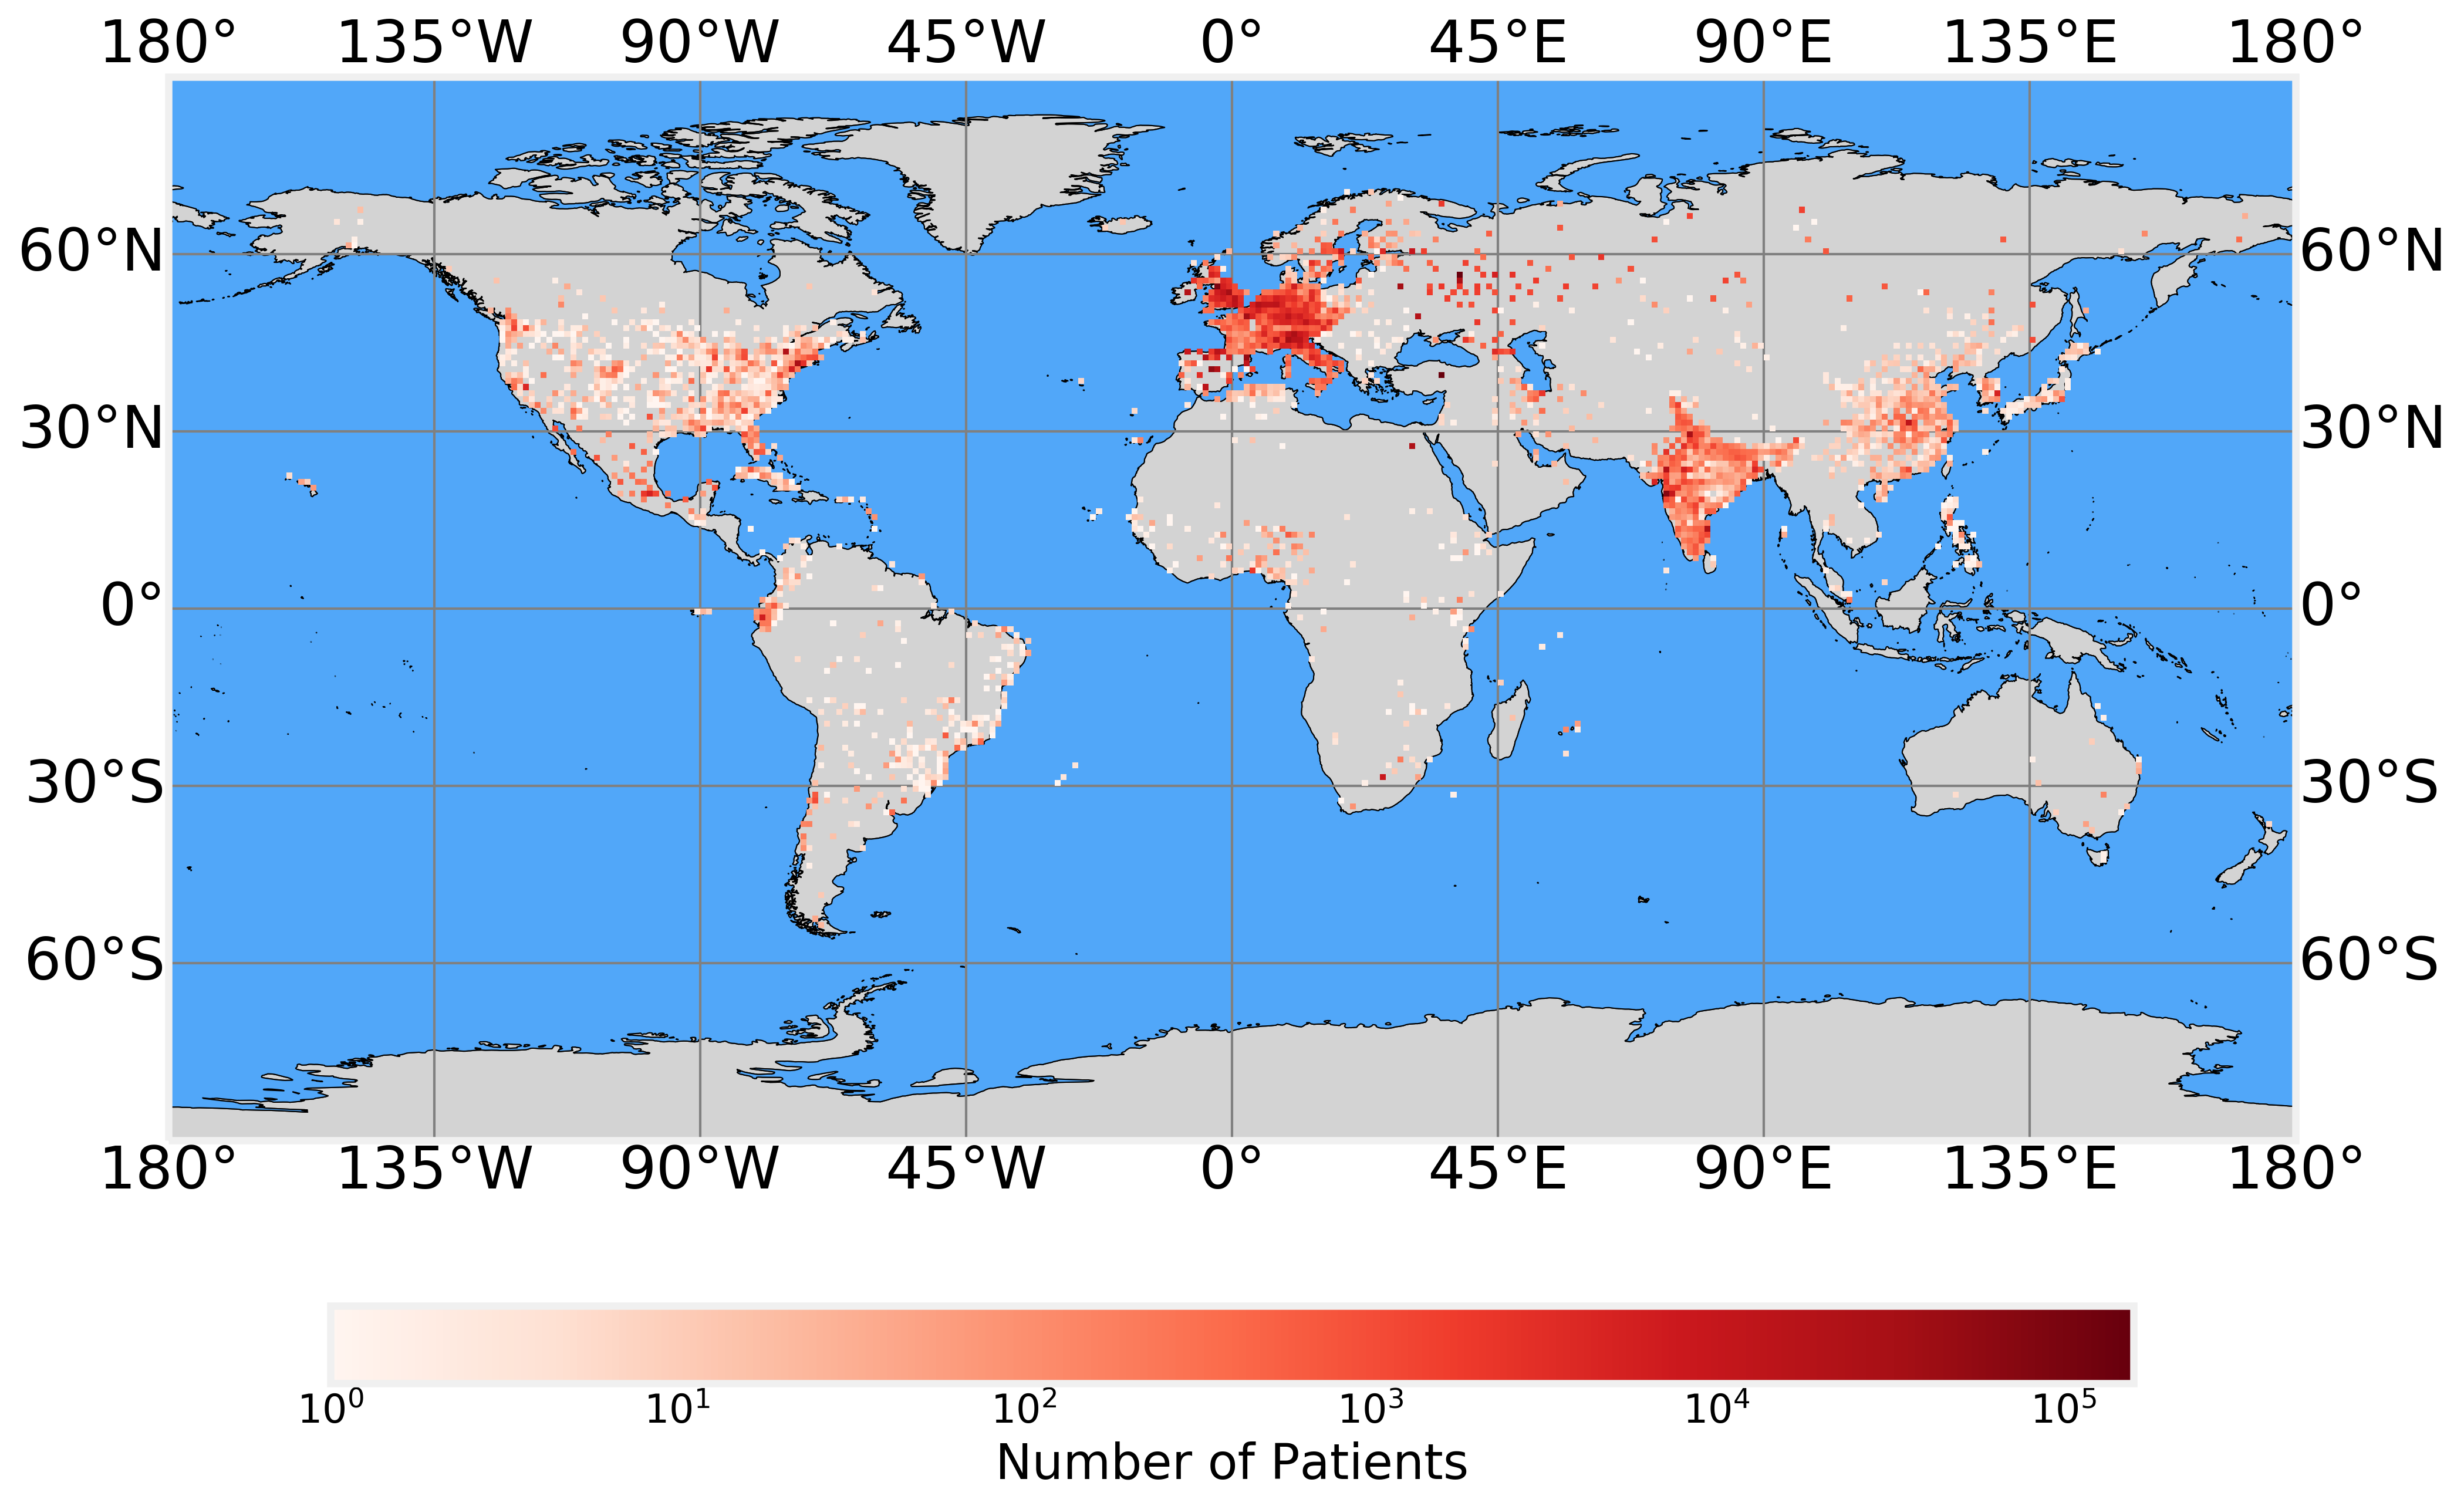

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())
fig = plt.gcf()
ax.set_global()
ax.coastlines()

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='lightgray'))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='k', facecolor=colors[0]))

vmin = np.log10(counts+1).min()
vmax = np.log10(counts+1).max()
norm = Normalize(vmin=vmin, vmax=vmax)

counts[counts==0] = np.nan

ax.imshow(np.log10(counts+1), origin='upper', extent=(-180, 180, 90, -90), cmap=plt.cm.Reds, zorder=3)

ax.gridlines(draw_labels=True, dms=True, 
             xlocs=np.arange(-180, 180.1, 45), 
             ylocs=np.arange(-90, 90.1, 30),
             x_inline=False, y_inline=False, color='gray')

cax = fig.add_axes([0.1, 0.00, 0.8, 0.05])

cb = ColorbarBase(cax, cmap=plt.cm.Reds, orientation='horizontal', norm=norm)
cb.ax.set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$', r'$10^5$'], fontsize=16)
cb.ax.set_xlabel('Number of Patients', fontsize=20)
fig.tight_layout()

## Country statistics

Count how many patients we have per country

In [10]:
country_counts = pd.DataFrame(Counter(data['country']).items(), columns=['Country', 'Patient_Count'])
country_counts.sort_values('Patient_Count', ascending=True, inplace=True)

In [11]:
country_counts.shape

(144, 2)

In [12]:
country_age_counts = pd.DataFrame(Counter(data[['country', 'age']].dropna()['country']).items(), columns=['Country', 'Age_Count'])
country_age_counts.sort_values('Age_Count', ascending=True, inplace=True)

In [13]:
country_stats = country_counts.merge(country_age_counts, how='left').fillna(0)

Select only countries with more than 1000 patients

In [14]:
country_stats = country_stats[country_stats.Patient_Count > 1000]

Visualize the histogram

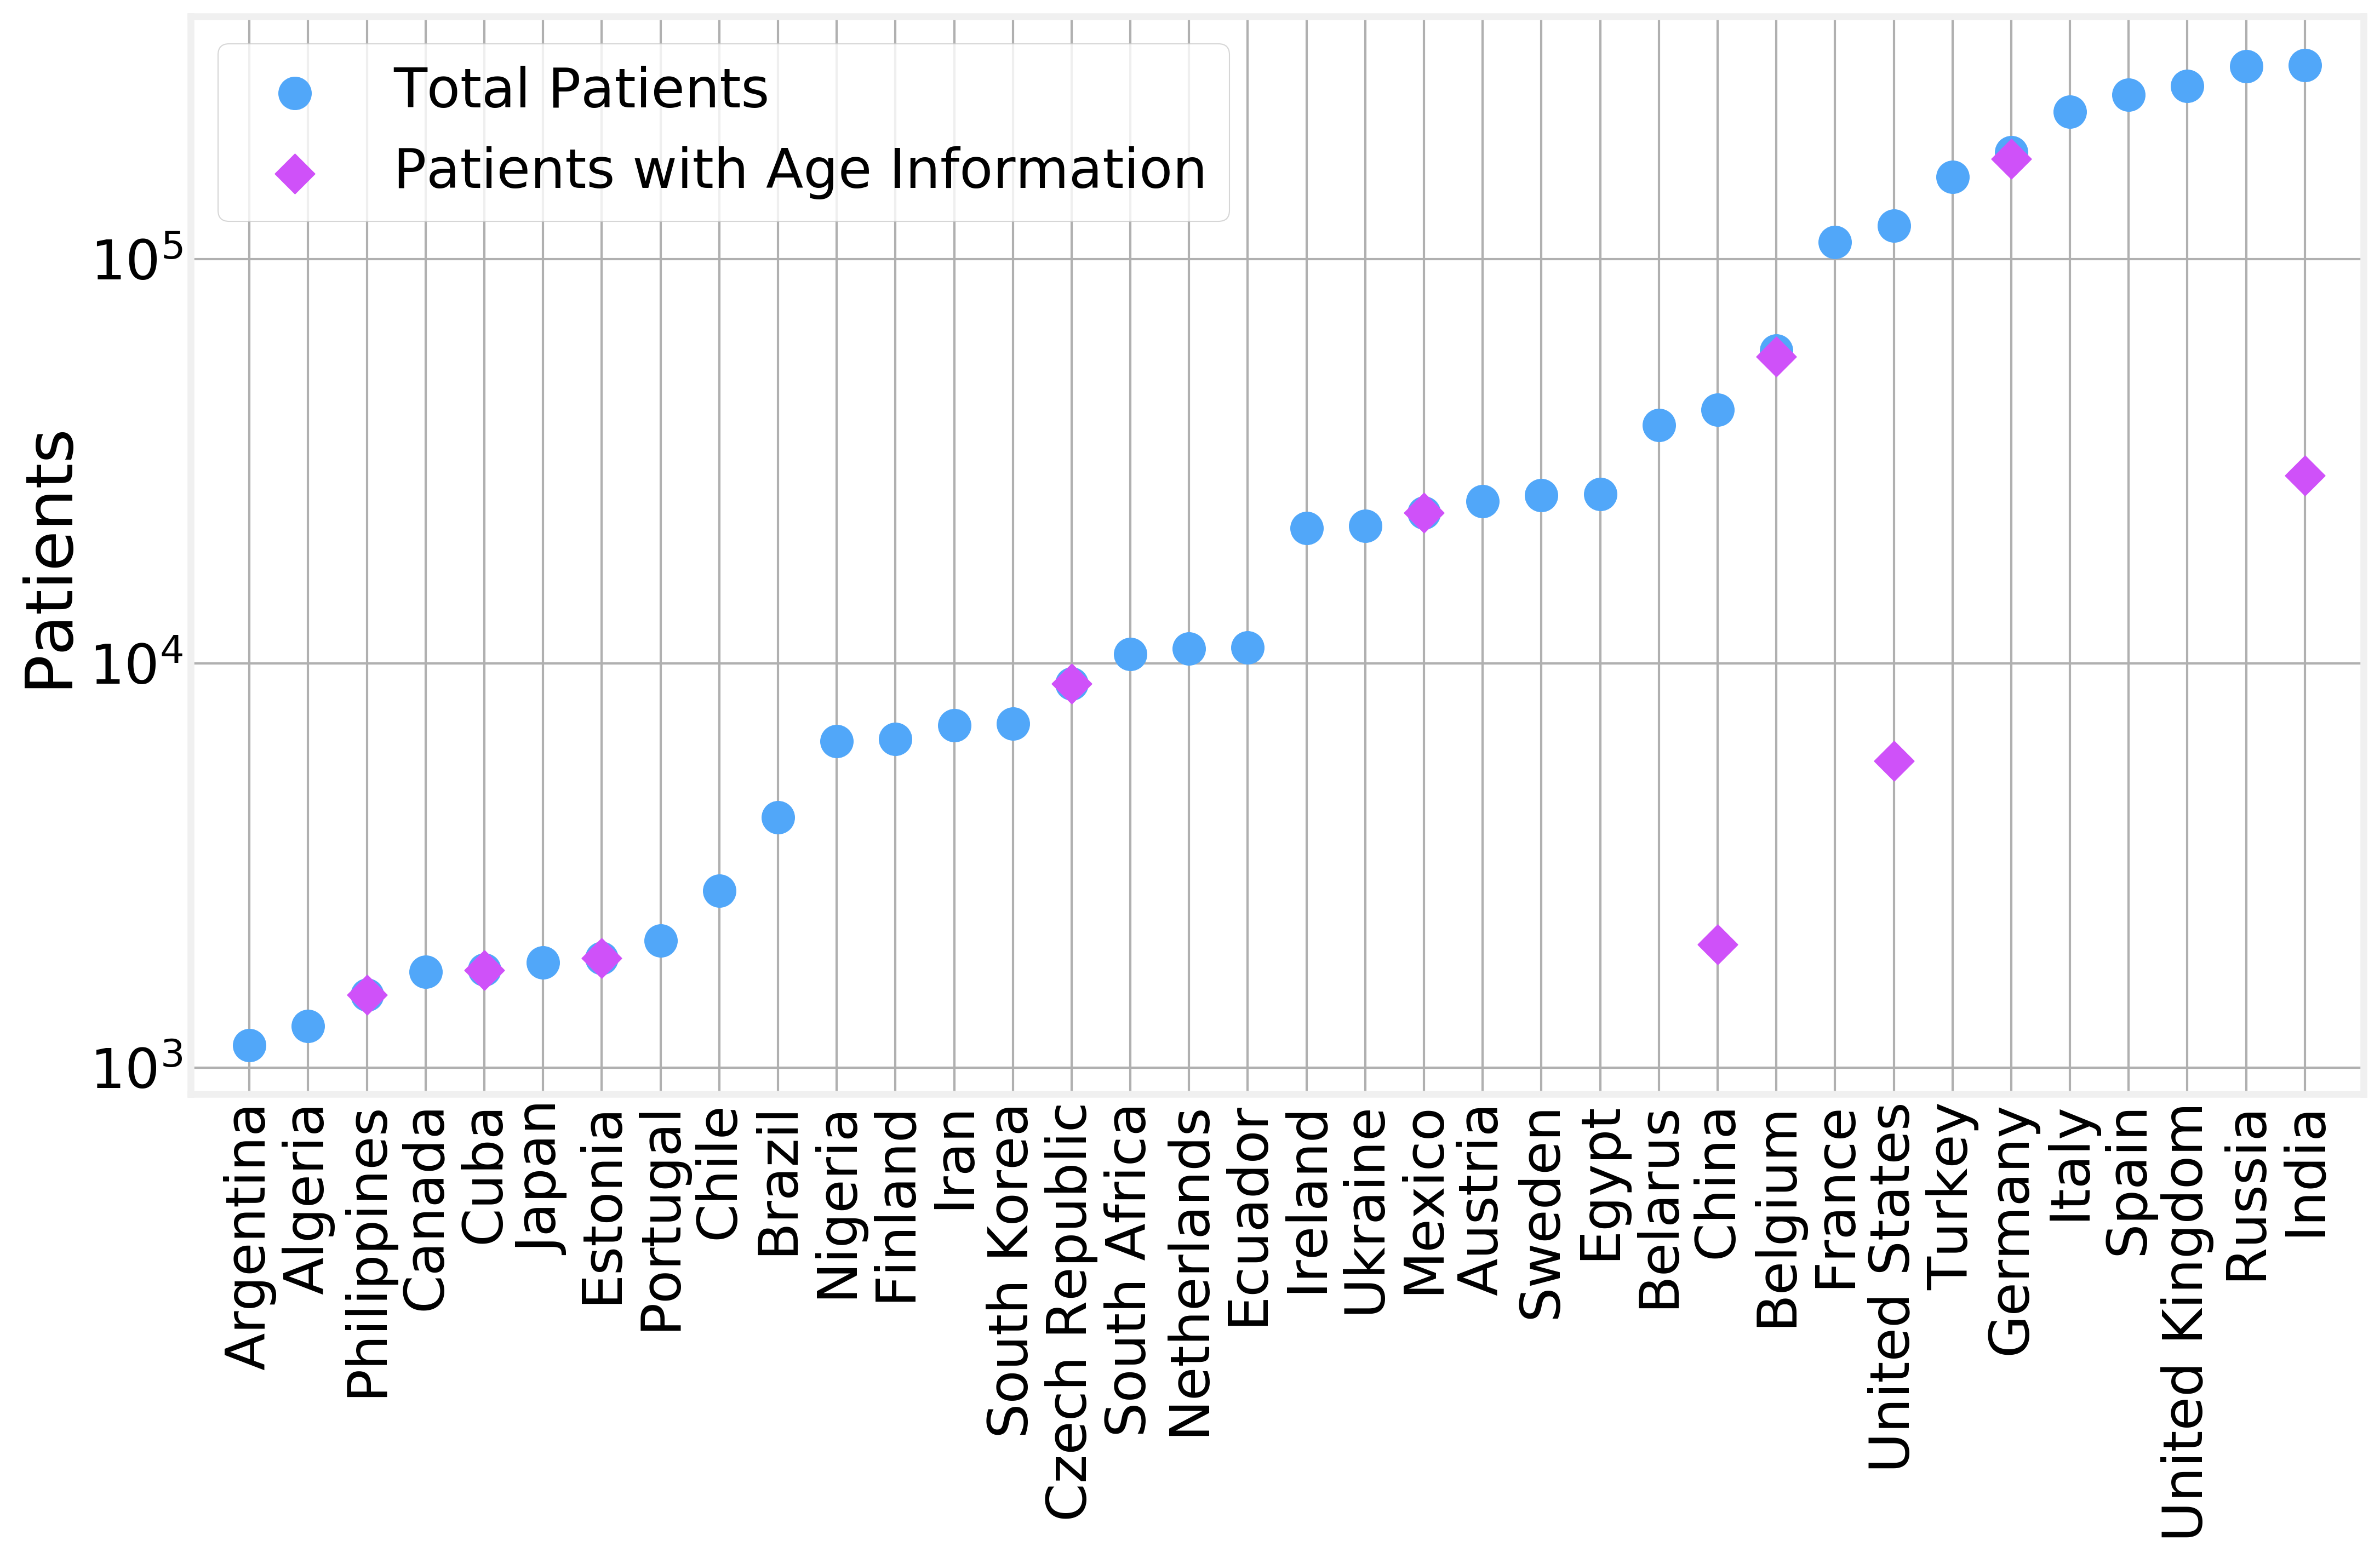

In [15]:
fig, ax = plt.subplots(1, figsize=(15,10))
ax.scatter(y=country_stats['Patient_Count'], x=np.arange(36), s=200, marker='o')
ax.scatter(y=country_stats['Age_Count'], x=np.arange(36), s=150, marker='D')
ax.set_xticks(np.arange(36))
ax.set_xticklabels(country_stats['Country'], rotation=90)
ax.set_yscale('log')
ax.set_xlim(-1, 36)
ax.set_ylabel('Patients')
ax.legend(['Total Patients', 'Patients with Age Information'])
fig.tight_layout()

## Delay between symptoms and case confirmation

The most interesting piece of information for each case is the date of onset of symptoms and the date when the case was first confirmed with rt-PCR. We parse the dates

In [16]:
data['date_onset_symptoms'] = pd.to_datetime(data['date_onset_symptoms'],  errors='coerce', format='%d.%m.%Y')
data['date_confirmation'] = pd.to_datetime(data['date_confirmation'], errors='coerce', format='%d.%m.%Y')

Let's keep only patients for which we have complete information

In [17]:
dates = data[['country', 'age', 'sex', 'date_onset_symptoms', 'date_confirmation']].dropna()

Of the original 2.3 million patients, we have symptom onset date and case confirmation dates for about 9%

In [18]:
dates.shape

(201631, 5)

And after we remove all the patients with symptoms happening only after test confirmation, we are down to 6% of the original

In [19]:
dates = dates[dates['date_confirmation'] > dates['date_onset_symptoms']].copy()
dates['count'] = 1
dates.shape

(136141, 6)

With a significantly biased distribution across countries

In [20]:
dates[['country', 'count']].groupby('country').sum().sort_values('count', ascending=False).head(10)

,count
country,
Germany,110762
Mexico,23123
China,910
Japan,504
Singapore,282
Cuba,201
South Korea,86
Philippines,79
Brazil,46


We tabulate the distribution of symptom onset for each case confirmation date

In [21]:
date_counts = pd.pivot_table(dates, columns='date_onset_symptoms', 
                              index='date_confirmation', 
                              values='count', aggfunc='sum')

Make sure we have a continuous range of dates

In [22]:
date_counts = date_counts.resample('D').sum()
date_counts = date_counts.T.resample('D').sum().T

Replace zeros with NaN for transparency

In [23]:
date_counts[date_counts==0] = np.nan

Generate the matrix plot

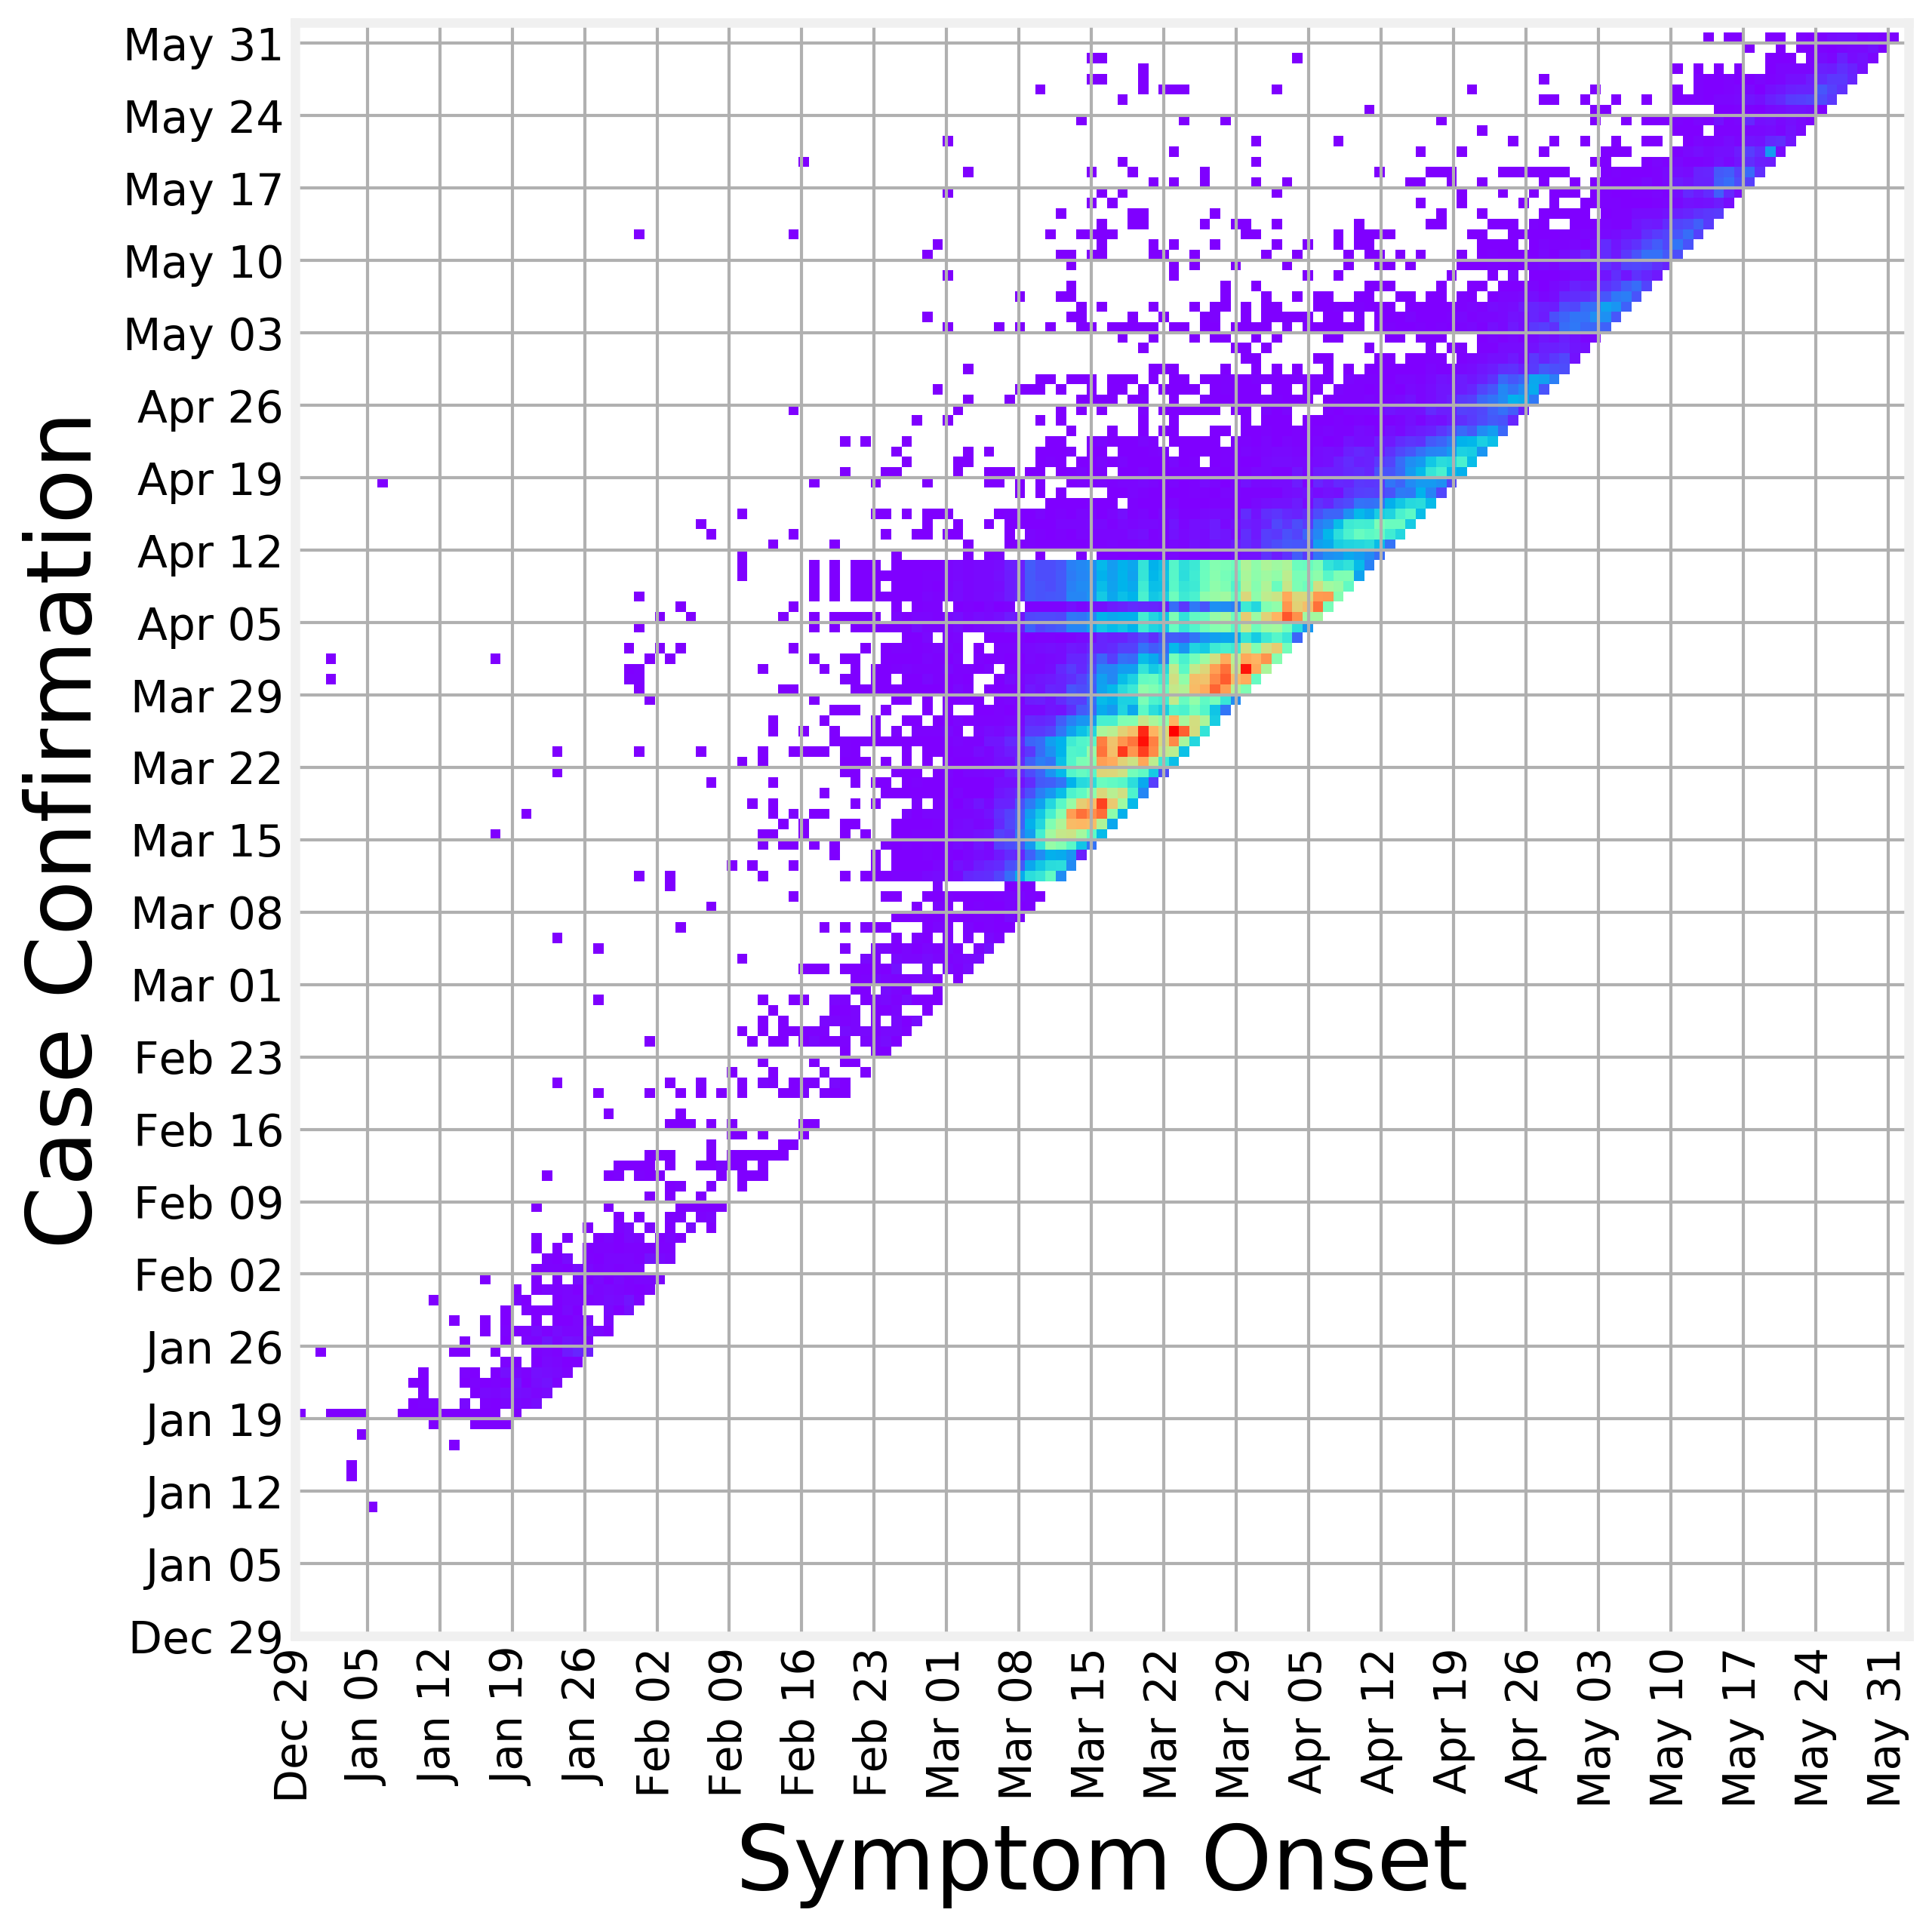

In [24]:
fig, ax = plt.subplots(1)

date_labels = [day.strftime('%b %d') for day in list(date_counts.columns)]

xlim, ylim = date_counts.shape
ax.imshow(date_counts.values, cmap=plt.cm.rainbow, origin='lower', extent=(0, 155, 12, 155))
ax.set_ylim(0, ylim)
ax.set_xlim(0, ylim)
ax.set_xticks(np.arange(0, ylim, 7))
ax.set_xticklabels(date_labels[::7], rotation=90, fontsize=14)
ax.set_yticks(np.arange(0, ylim, 7))
ax.set_yticklabels(date_labels[::7], fontsize=14)
ax.set_xlabel('Symptom Onset')
ax.set_ylabel('Case Confirmation')
fig.patch.set_facecolor('#FFFFFF')

## Age Group Analysis

Germany is the country with the most complete information. So we'll use it to look for any changes in behavior due to age group or gender

In [25]:
germany = dates[dates['country'] == 'Germany'].copy()

Clean up the age field

In [26]:
age_groups = pd.read_csv('data/age_groups.csv')
germany['age_group'] = germany['age'].map(dict(age_groups.values))
germany = germany[germany['age_group'] != 'NaN'].copy()

We have several thousand cases for each of our 6 age groups

In [27]:
pd.pivot_table(germany[['age_group', 'sex', 'count']], index='age_group', columns='sex', values='count', aggfunc='sum')

sex,female,male
age_group,,
00-04,459,460
05-14,1095,1070
15-34,14911,13364
35-59,25832,23168
60-79,9818,11037
80+,5633,3913


In [28]:
germany_clean = germany[['age_group', 'sex', 'date_onset_symptoms', 'date_confirmation']].dropna()

In [29]:
germany_clean['delta'] = germany_clean['date_confirmation']-germany_clean['date_onset_symptoms']
germany_clean['counts'] = 1

In [30]:
germany_counts = germany_clean[['age_group', 'sex', 'delta', 'counts']].groupby(['age_group', 'sex', 'delta'], as_index=False).sum()

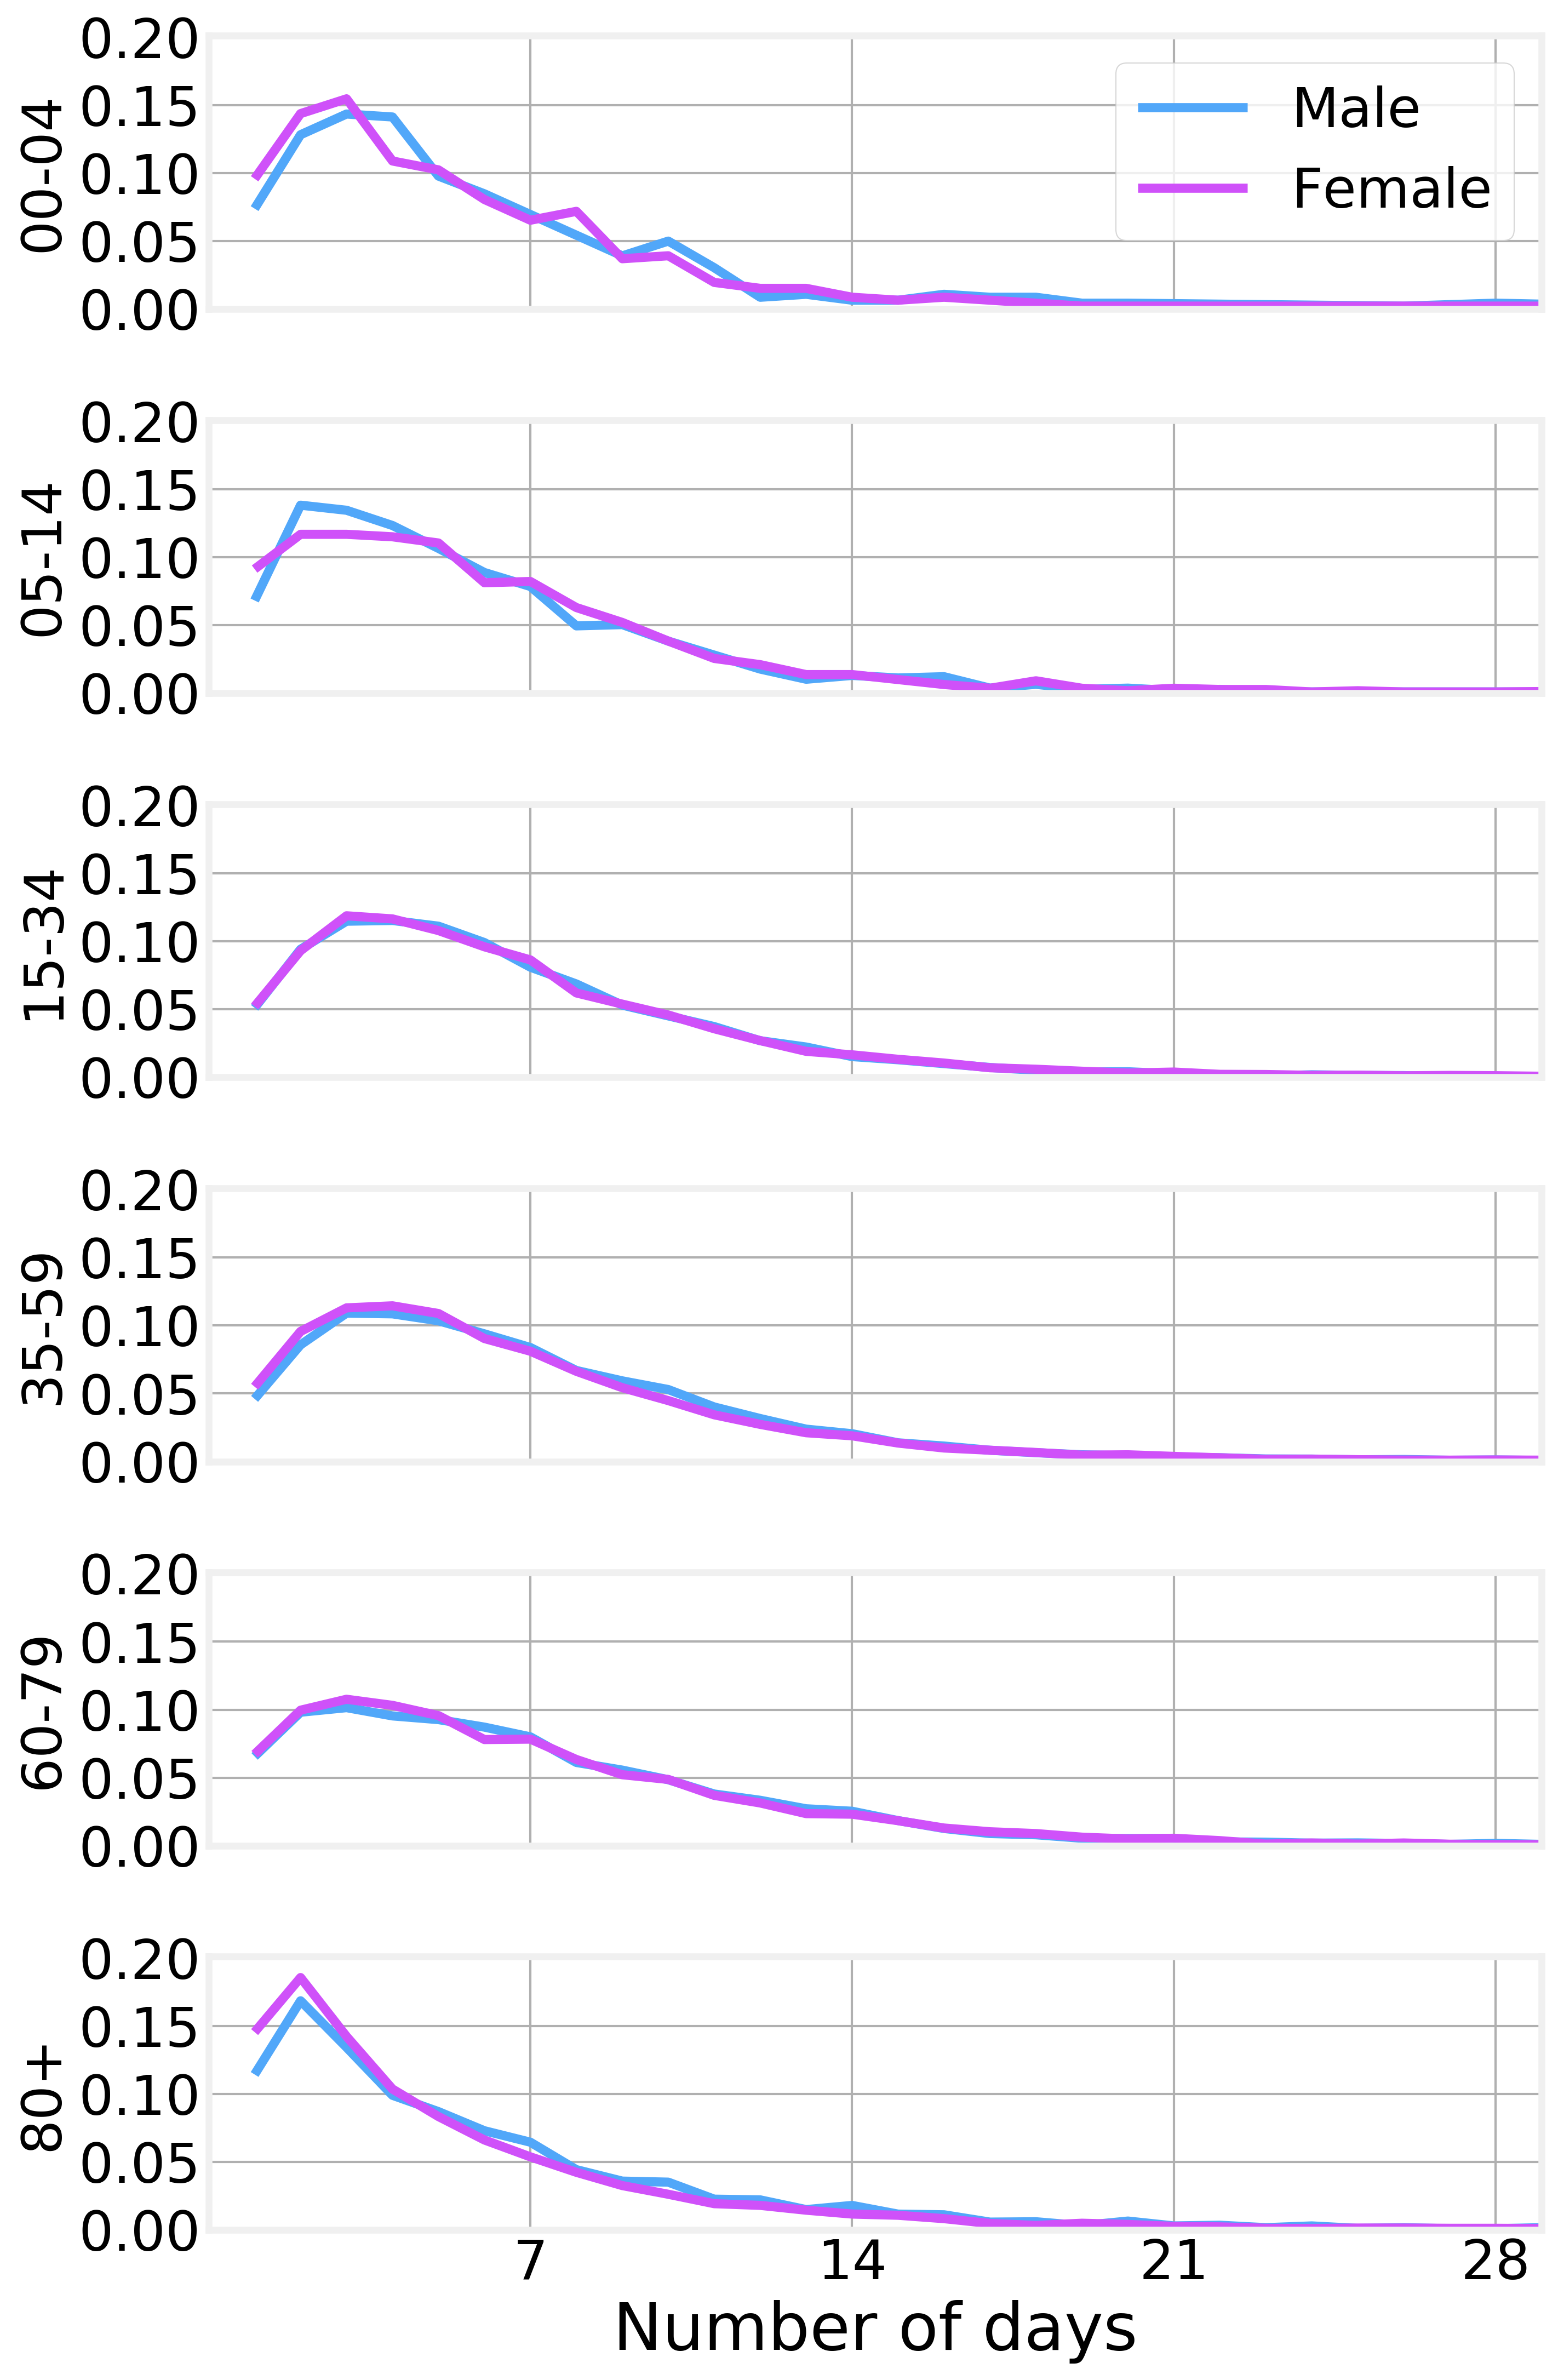

In [31]:
fig, ax_lst = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10, 15))

ages = ['00-04', '05-14', '15-34', '35-59', '60-79', '80+']
genders = ['male', 'female']

for i, age in enumerate(ages):
    for j, gender in enumerate(genders):
        current = germany_counts[(germany_counts['age_group'] == age) & (germany_counts['sex'] == gender)].copy()
        current = current.sort_values('delta')
        ax_lst[i].plot(current['delta'].dt.days, (current['counts']/current['counts'].sum()))
    
    ax_lst[i].set_ylabel(age, fontsize=24)

ax_lst[-1].set_xlabel('Number of days')
ax_lst[0].set_xlim(0, 29)
ax_lst[0].set_ylim(0, 0.201)
ax_lst[0].set_xticks([7, 14, 21, 28])
ax_lst[0].set_yticks([0, 0.05, 0.10, 0.15, 0.20])
ax_lst[0].legend(['Male', 'Female'], loc='upper right')
fig.tight_layout()

In [32]:
germany['delay'] = (germany['date_confirmation'] - germany['date_onset_symptoms']).dt.days

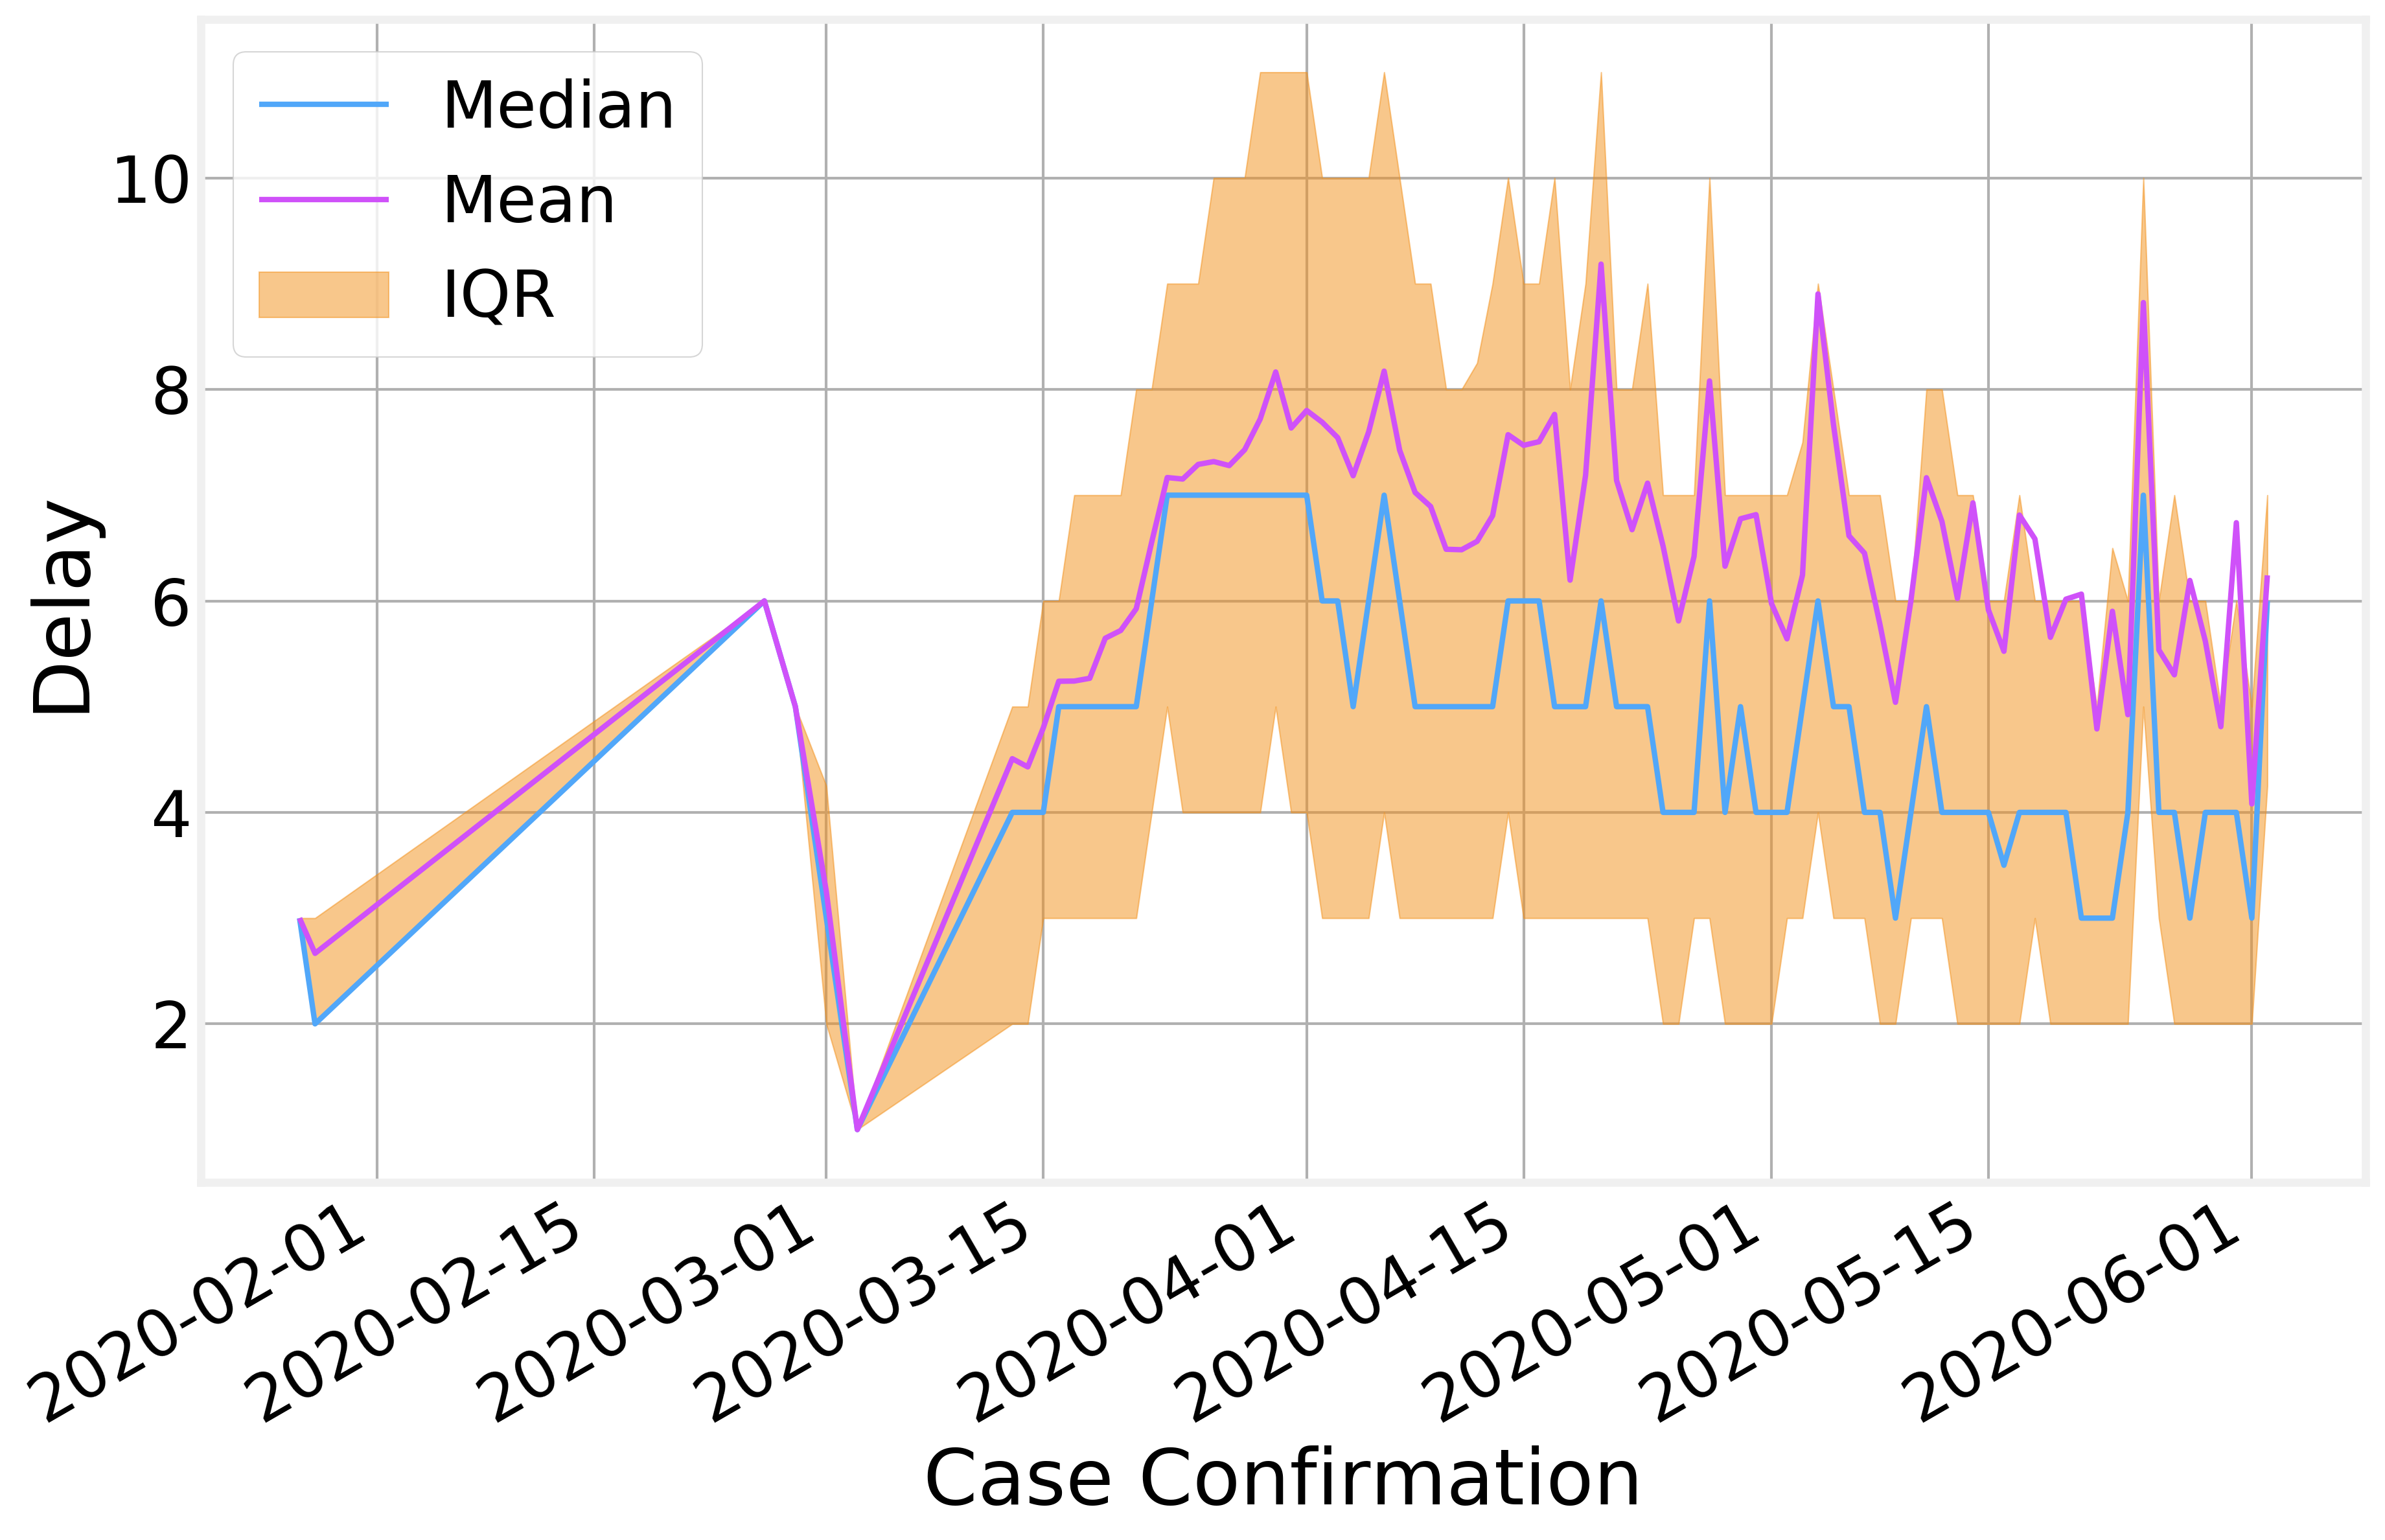

In [33]:
ax = germany[['date_confirmation', 'delay']].groupby('date_confirmation').median().plot(label='Median', lw=2, c=colors[0])
germany[['date_confirmation', 'delay']].groupby('date_confirmation').mean().plot(label='Mean', ax=ax, lw=2, c=colors[1])
q25 = germany[['date_confirmation', 'delay']].groupby('date_confirmation').quantile(.25).values.flatten()
q75 = germany[['date_confirmation', 'delay']].groupby('date_confirmation').quantile(.75).values.flatten()
ax.fill_between(x=germany['date_confirmation'].sort_values().unique(), y1=q25, y2=q75, color=colors[3], alpha=0.5)
ax.set_xlabel('Case Confirmation')
ax.set_ylabel('Delay')
ax.legend(['Median', 'Mean', 'IQR'])

In [34]:
germany[['date_confirmation', 'date_onset_symptoms', 'count']].groupby(['date_confirmation', 'date_onset_symptoms'], as_index=False).sum()

,date_confirmation,date_onset_symptoms,count
0,2020-01-27,2020-01-24,1
1,2020-01-28,2020-01-24,1
2,2020-01-28,2020-01-26,2
3,2020-02-26,2020-02-20,1
4,2020-02-28,2020-02-23,1
...,...,...,...
2606,2020-06-02,2020-05-28,12
2607,2020-06-02,2020-05-29,4
2608,2020-06-02,2020-05-30,5
2609,2020-06-02,2020-05-31,3


## Average behavior across all cases

As the changes across age groups and genders are minimal, we calculate the total distribution in order to have better statistics. This has the added advantage of allowing us to apply this approach to countries for which we don't have age information

In [35]:
germany_mean = germany_clean[['delta', 'counts']].groupby('delta', as_index=False).sum()
germany_mean['delay'] = germany_mean.delta.dt.days

And now we calculate the distribution of delays

In [36]:
germany_delay = germany_mean[['delay', 'counts']].set_index('delay').sort_index()
new_range = np.arange(0, germany_delay.index.max()+1)
germany_delay = germany_delay.reindex(new_range, fill_value=0)
germany_delay /= germany_delay.sum()

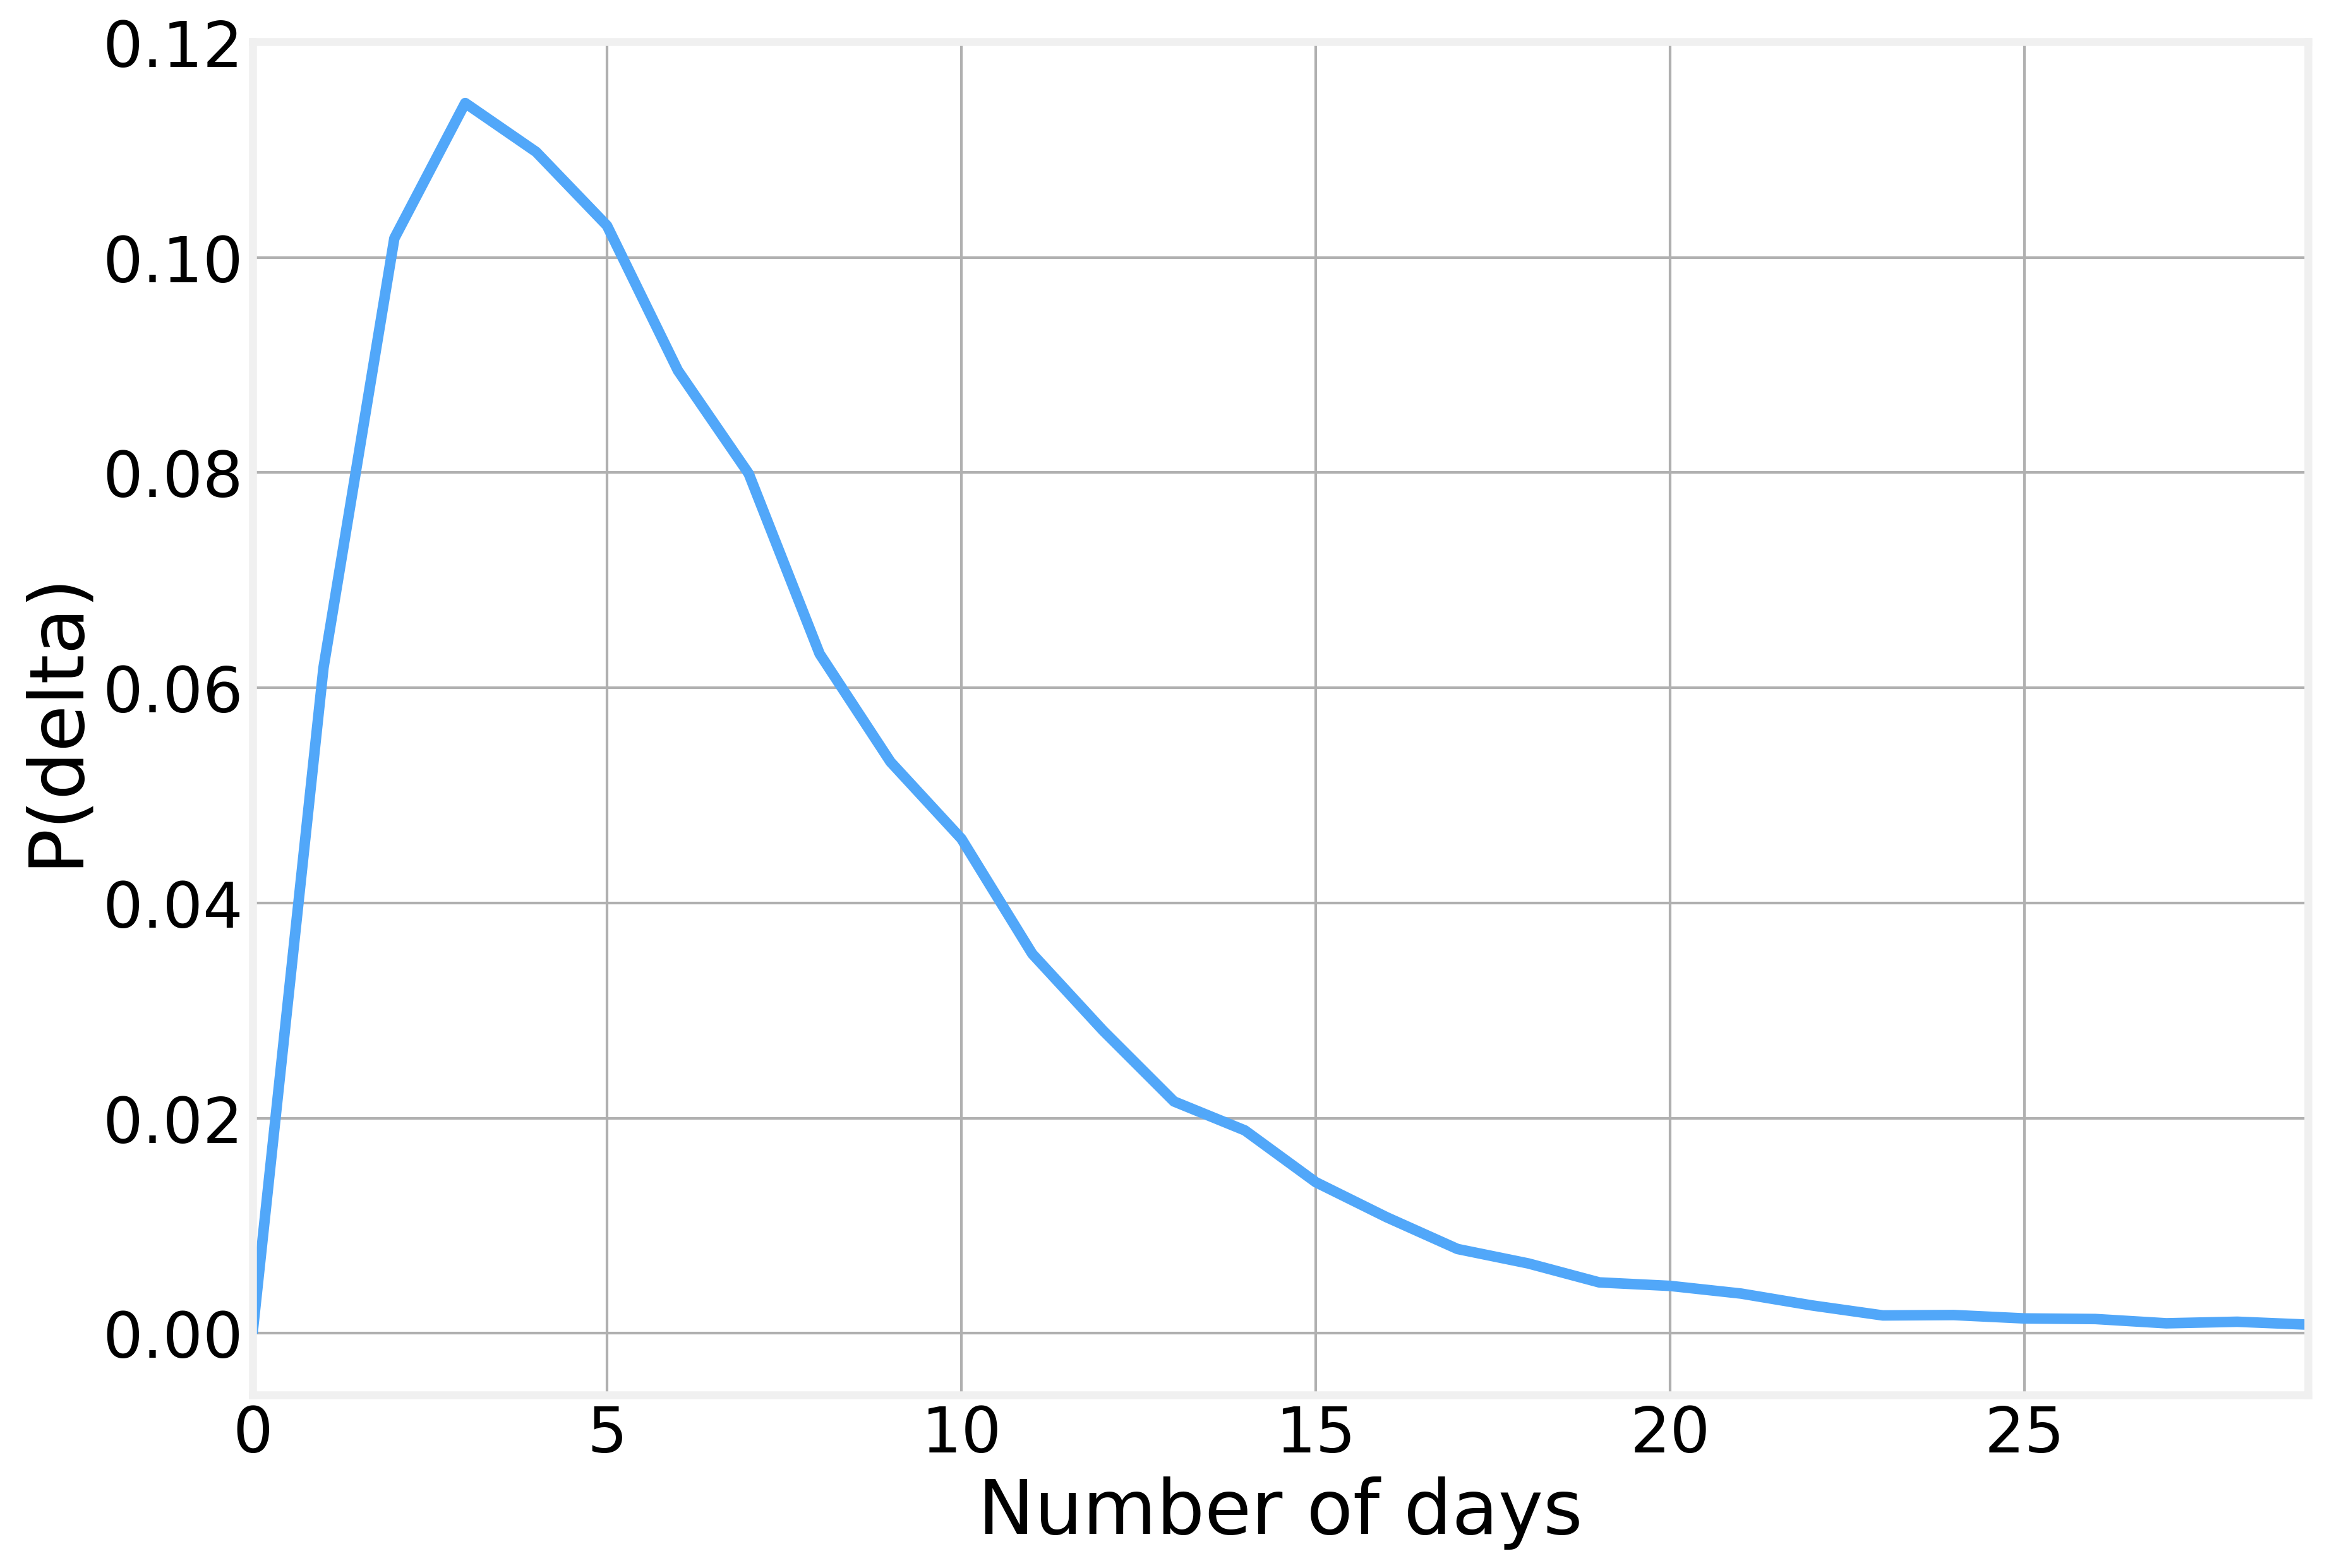

In [37]:
fig, ax = plt.subplots(1)

ax.plot(germany_delay.index, germany_delay)
ax.set_ylabel('P(delta)')
ax.set_xlabel('Number of days')
ax.set_xlim(0, 29)
fig.tight_layout()

## Convert confirmed cases to onset dates

Now that we have the distribution of delay times between symptom onset and case confirmation, we can use it to estimate the temporal evolution of symptom onsets for Germany. Inspired by https://github.com/k-sys/covid-19

Get the official number of confirmed cases form the JHU dataset. You can take a deeper look at how to analyze this dataset in the [Epidemiology001](Epidemiology001.ipynb) notebook.

In [38]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
confirmed = pd.read_csv(url + 'time_series_covid19_confirmed_global.csv')

In [39]:
del_columns = [
 'Province/State',
 'Lat',
 'Long',
]

In [40]:
confirmed_timeline = confirmed.drop(columns=del_columns).groupby('Country/Region').sum().T
confirmed_timeline.index = pd.to_datetime(confirmed_timeline.index)

Extract the values for Germany

In [41]:
germany_confirmed = confirmed_timeline['Germany'].diff(1).dropna()

We estimate the distribution of onset dates by distributing all the cases confirmed today across all previous days according to the delay distribution. Mathematically, this can be calculated as a [convolution](https://en.wikipedia.org/wiki/Convolution) between the number of cases and the delay distribution. A more precise approach would use a multinomial distibution to assign each confirmed case to a onset date, but if the numbers of cases are sufficiently large the difference will be small. Here we invert the temporal order of the confirmed values in order to convolve cases into the past.

In [42]:
germany_convolved = np.convolve(germany_confirmed[::-1].values, germany_delay['counts'])

As we now have (potentially) extended furth back in the  past than our original time period, we have to manually calculate the new index dates.

In [43]:
new_dates = pd.date_range(end=germany_confirmed.index.max(), periods=len(germany_convolved))
germany_onset = pd.Series(np.flip(germany_convolved), index=new_dates)

And finally, we can compare the timelines of case confirmation and symptom onsets

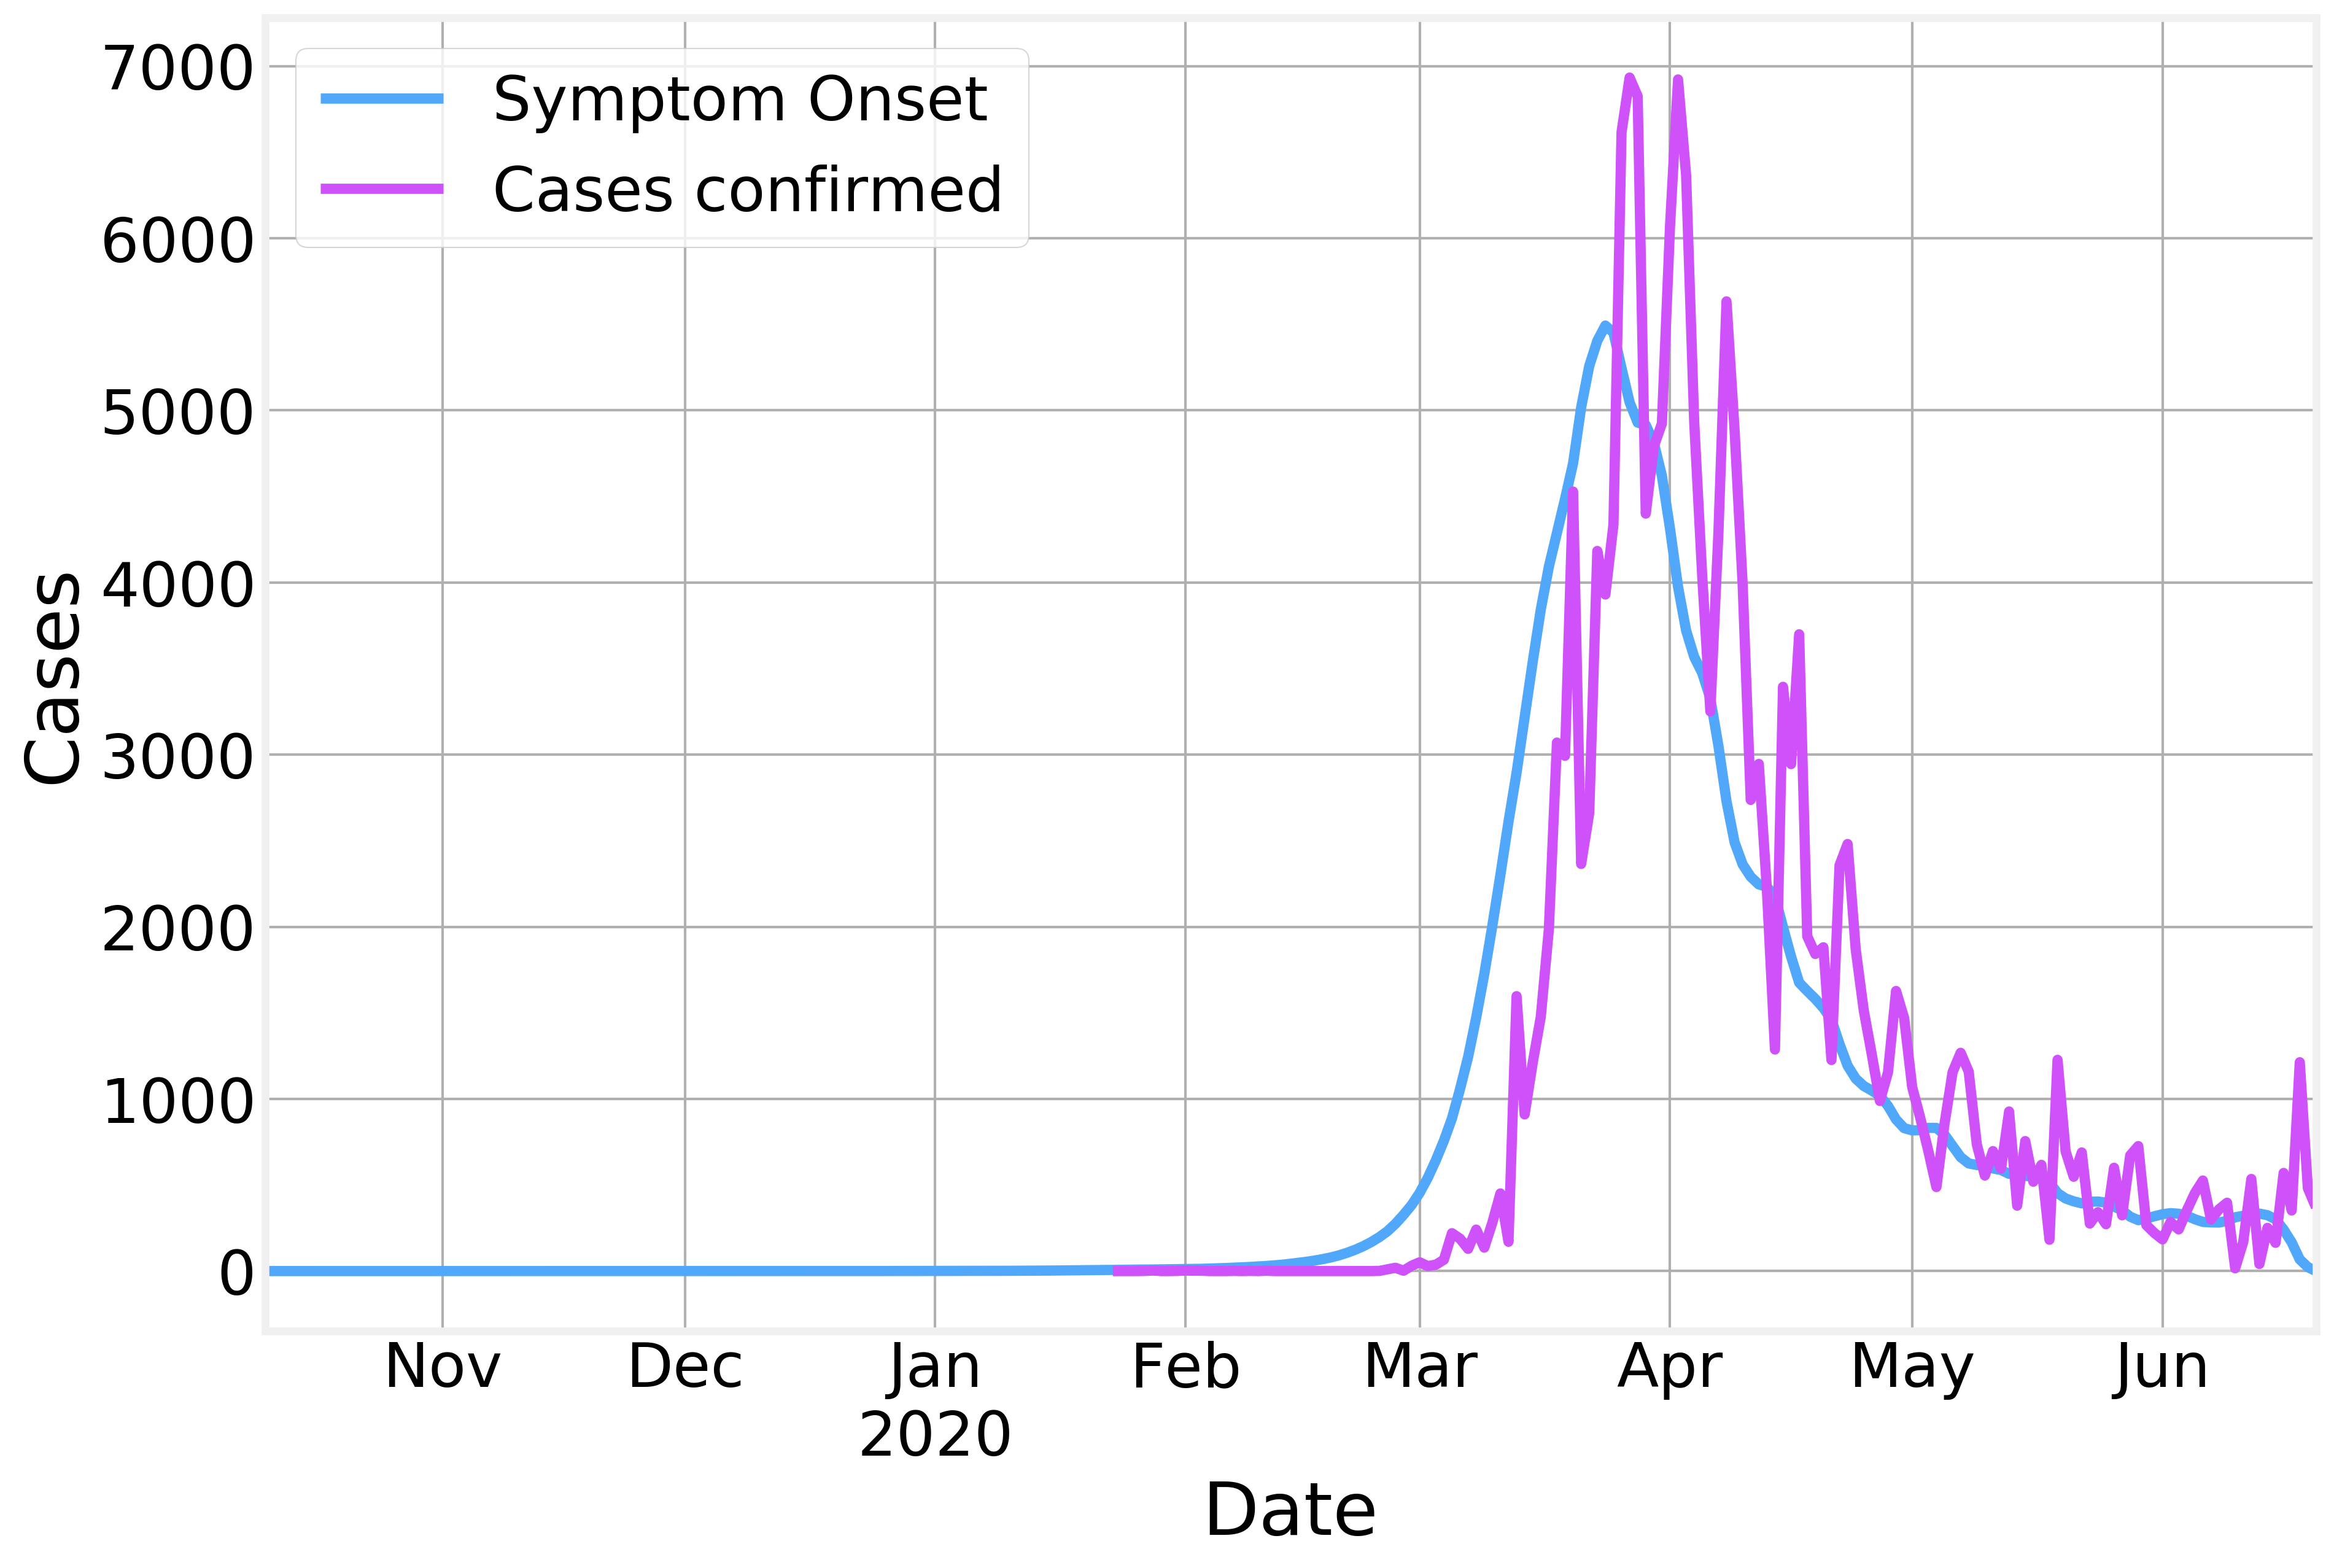

In [44]:
ax = germany_onset.plot(label='Symptom Onset')
germany_confirmed.plot(ax=ax, label='Cases confirmed')
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
ax.legend()

As we can see, by using this approach we obtained a much cleaner timeline for the epidemic in Germany. As the time delay distribution is infered empirically, it is even able to remove the circadian variations between weekdays and weekends.

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>